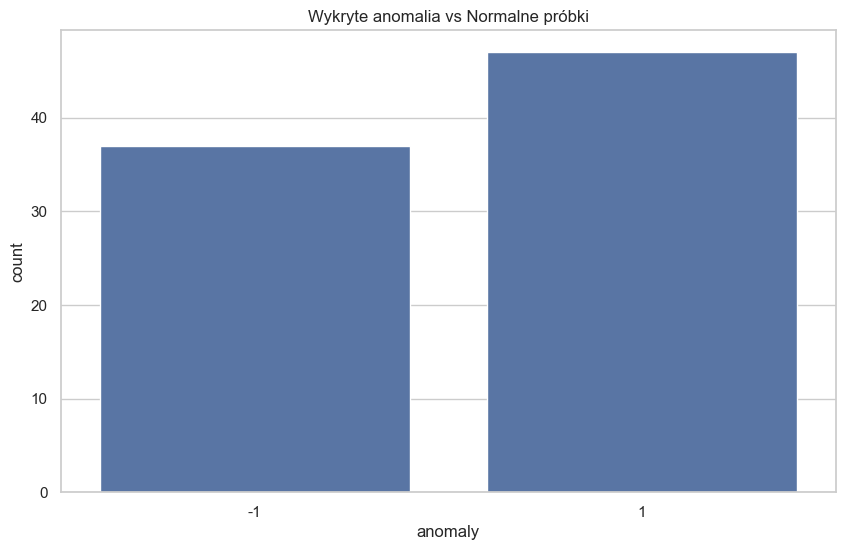

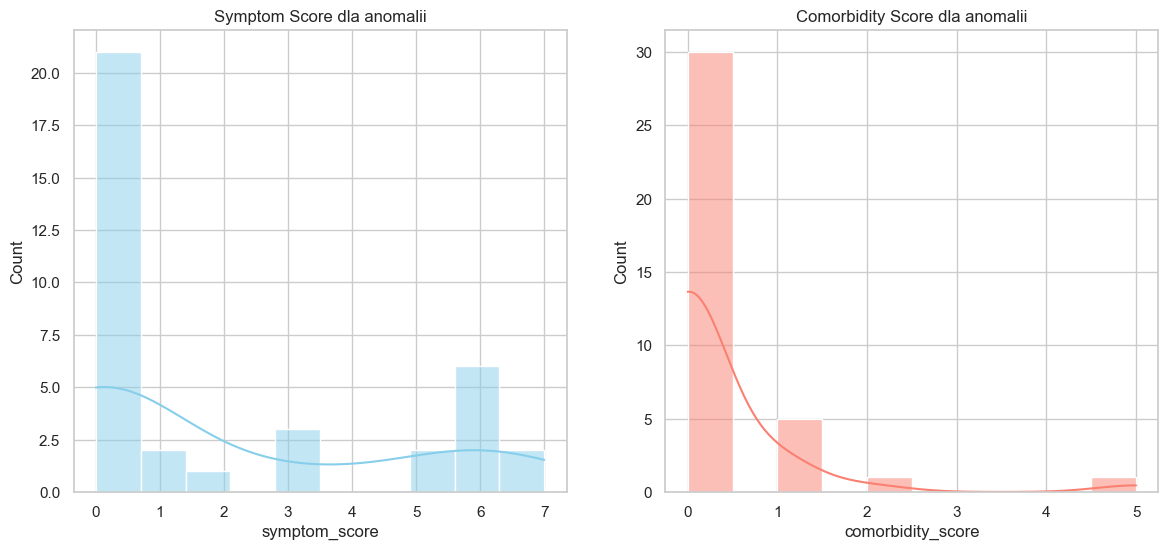

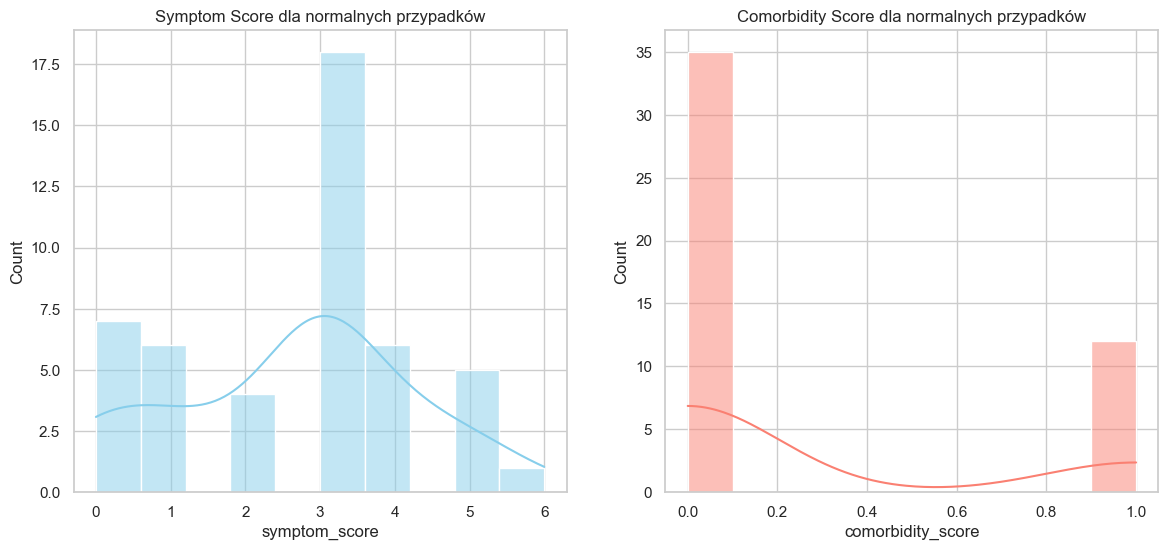

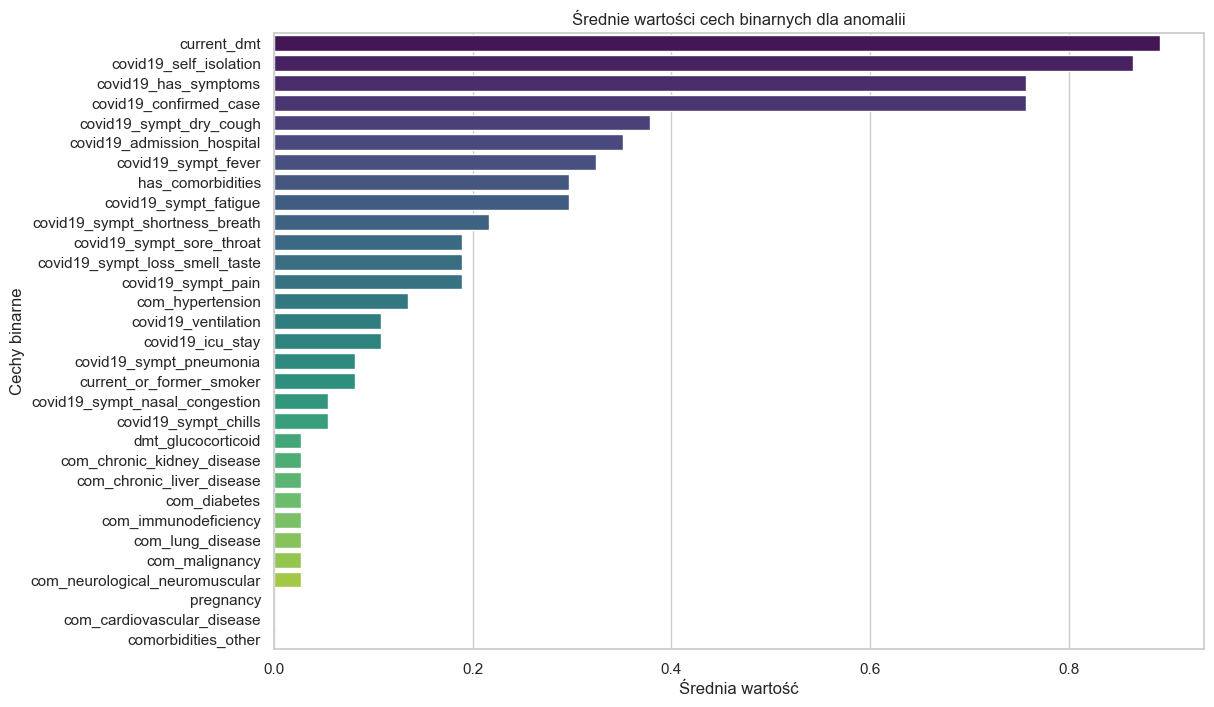

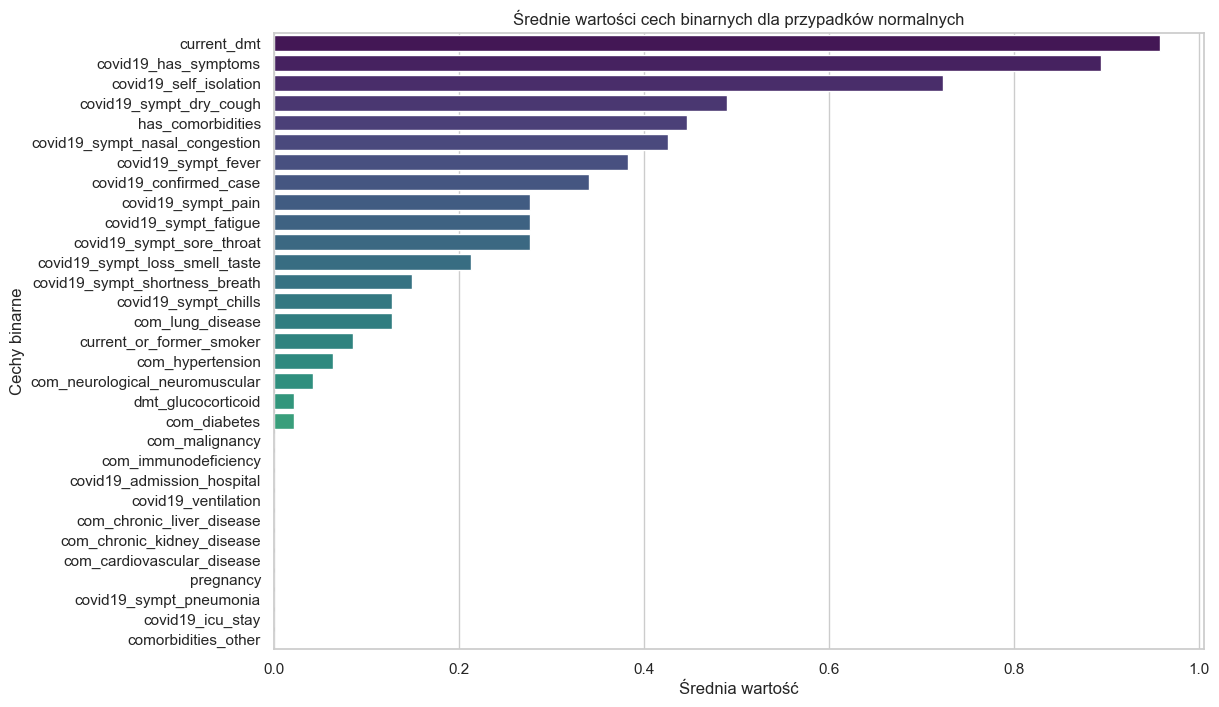

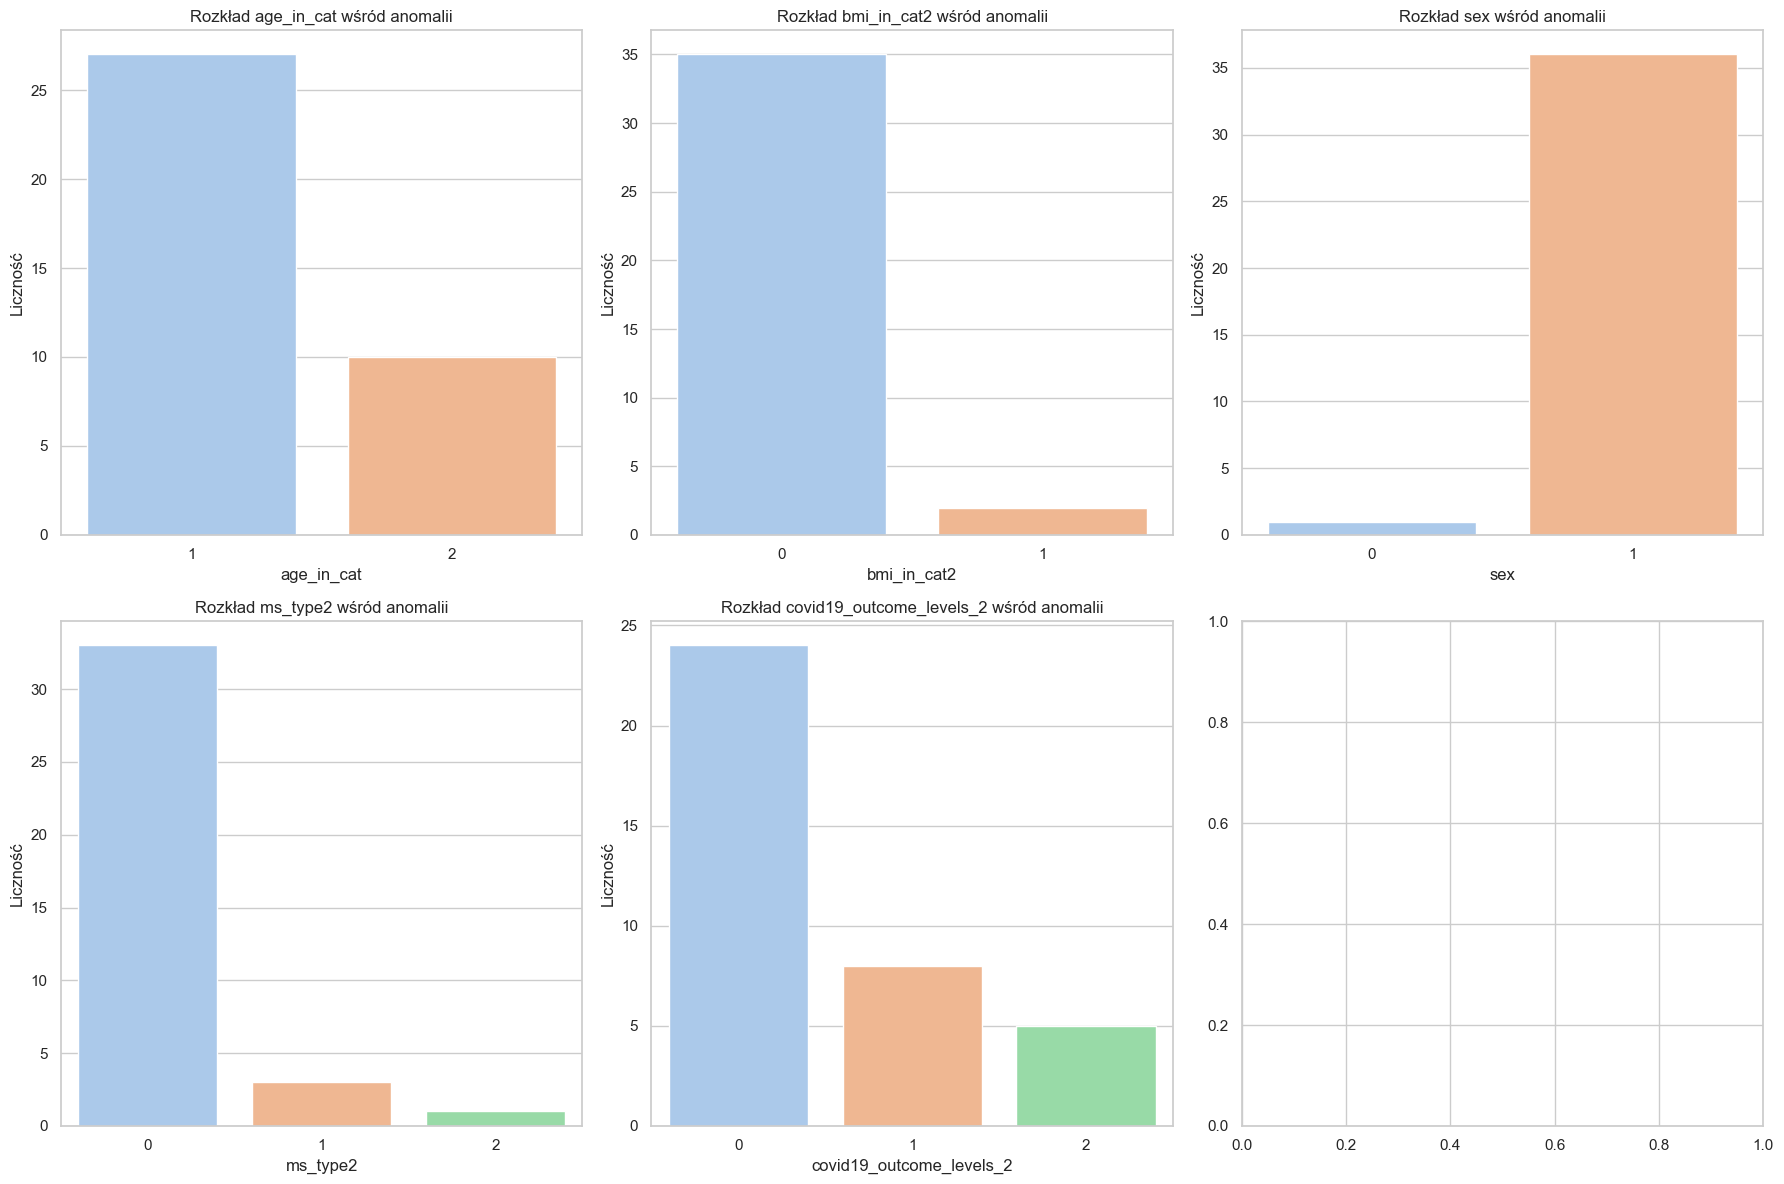

Ocena modelu One-Class SVM:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        37
     Anomaly       1.00      1.00      1.00        47

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Macierz pomyłek:
[[37  0]
 [ 0 47]]
ROC AUC: 1.0
Procent wykrytych anomalii (TPR): 100.00%
False Positive Rate (FPR): 0.00%


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

file = pd.read_csv('GDSI_OpenDataset_Final.csv', index_col=0)

features = ['report_source', 'age_in_cat', 'bmi_in_cat2', 'covid19_admission_hospital', 'covid19_confirmed_case', 'covid19_diagnosis', 'covid19_has_symptoms', 'covid19_icu_stay', 'covid19_self_isolation', 'covid19_sympt_chills', 'covid19_sympt_dry_cough', 'covid19_sympt_fatigue', 'covid19_sympt_fever', 'covid19_sympt_loss_smell_taste', 'covid19_sympt_nasal_congestion', 'covid19_sympt_pain', 'covid19_sympt_pneumonia', 'covid19_sympt_shortness_breath', 'covid19_sympt_sore_throat', 'covid19_ventilation', 'current_dmt', 'dmt_glucocorticoid', 'edss_in_cat2', 'pregnancy', 'current_or_former_smoker', 'has_comorbidities', 'com_cardiovascular_disease', 'com_chronic_kidney_disease', 'com_chronic_liver_disease', 'com_diabetes', 'com_hypertension', 'com_immunodeficiency', 'com_lung_disease', 'com_malignancy', 'com_neurological_neuromuscular', 'comorbidities_other', 'dmt_type_overall', 'covid19_outcome_levels_2', 'ms_type2', 'sex']

data = file[features].copy()

# Yes/No kolumny - czyszczenie
binary_columns = ['covid19_admission_hospital', 'covid19_confirmed_case', 'covid19_has_symptoms', 'covid19_icu_stay', 'covid19_self_isolation', 'covid19_sympt_chills', 'covid19_sympt_dry_cough', 'covid19_sympt_fatigue', 'covid19_sympt_fever', 'covid19_sympt_loss_smell_taste', 'covid19_sympt_nasal_congestion', 'covid19_sympt_pain', 'covid19_sympt_pneumonia', 'covid19_sympt_shortness_breath', 'covid19_sympt_sore_throat', 'covid19_ventilation', 'current_dmt', 'dmt_glucocorticoid', 'pregnancy', 'current_or_former_smoker', 'has_comorbidities', 'com_cardiovascular_disease', 'com_chronic_kidney_disease', 'com_chronic_liver_disease', 'com_diabetes', 'com_hypertension', 'com_immunodeficiency', 'com_lung_disease', 'com_malignancy', 'com_neurological_neuromuscular', 'comorbidities_other']
data[binary_columns] = data[binary_columns].map(lambda x: 1 if x == 'yes' else 0)

# Pozostale kolumny - czyszczenie
ordinal_mapping = {'age_in_cat': {'0': 0, '1': 1, '2': 2, '3': 3},
                   'covid19_outcome_levels_2': {'0': 0, '1': 1, '2': 2},
                   'report_source': {'clinicians': 1, 'patients': 0},
                   'bmi_in_cat2': {'not_overweight': 0, 'overweight': 1},
                   'covid19_diagnosis': {'not_suspected': 0, 'suspected': 1, 'confirmed': 2},
                   'current_dmt': {'yes': 2, 'no': 1, 'never_treated': 0},
                   'sex': {'male': 0, 'female': 1},
                   'ms_type2': {'relapsing_remitting': 0, 'progressive_MS': 1, 'other': 2},
                   'dmt_type_overall': {'No information on DMT use': 0,
                                        'currently not using any DMT': 1,
                                        'currently on interferon': 2, 
                                        'currently on glatiramer': 3,
                                        'currently on natalizumab': 4, 
                                        'currently on fingolimod': 5,
                                        'currently on dimethyl fumarate': 6,
                                        'currently on teriflunomide': 7,
                                        'currently on alemtuzumab': 8,
                                        'currently on cladribine': 9,
                                        'currently on siponimod': 10,
                                        'currently on rituximab': 11,
                                        'currently on ocrelizumab': 12,
                                        'currently on another drug not listed': 13},
                                        'covid19_outcome_recovered': {'no': 0, 'yes': 1, 'not_applicable':2}
                   }
pd.set_option('future.no_silent_downcasting', True)
data.replace(ordinal_mapping, inplace=True)

# Zaminana nieznanych wartosci na zera
data.fillna(0, inplace=True)

# Zbieranie symptomow razem
symptom_columns = [col for col in data.columns if 'covid19_sympt_' in col]
comorbidity_columns = [col for col in data.columns if 'com_' in col]

data['symptom_score'] = data[symptom_columns].apply(lambda row: (row == 1).sum(), axis=1)
data['comorbidity_score'] = data[comorbidity_columns].apply(lambda row: (row == 1).sum(), axis=1)

# Odchylenie standardowe
scaler = StandardScaler()

# Skalowanie wybranych kolumn i dodanie wyników jako nowe kolumny
data['symptom_score_scaled'] = scaler.fit_transform(data[['symptom_score']])
data['comorbidity_score_scaled'] = scaler.fit_transform(data[['comorbidity_score']])

# Przetrenowany na osobach bez chorob współistniejących 70%
X_train = data[data['report_source'] == 0]
X_test = data[data['report_source'] == 1].copy()

from sklearn.svm import OneClassSVM

# Trenowanie 
model = OneClassSVM(gamma='auto', kernel='rbf', nu=0.1)
model.fit(X_train)
predictions = model.predict(X_test)
X_test['anomaly'] = predictions
anomalies = X_test[predictions == -1]
normals = X_test[predictions == 1]

# Wykresy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x='anomaly', data=X_test)
plt.title('Wykryte anomalia vs Normalne próbki')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(anomalies['symptom_score'], bins=10, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Symptom Score dla anomalii')
sns.histplot(anomalies['comorbidity_score'], bins=10, kde=True, color='salmon', ax=ax[1])
ax[1].set_title('Comorbidity Score dla anomalii')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(normals['symptom_score'], bins=10, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Symptom Score dla normalnych przypadków')
sns.histplot(normals['comorbidity_score'], bins=10, kde=True, color='salmon', ax=ax[1])
ax[1].set_title('Comorbidity Score dla normalnych przypadków')
plt.show()

binary_anomaly_means = anomalies[binary_columns].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=binary_anomaly_means.values, y=binary_anomaly_means.index, palette='viridis', hue=binary_anomaly_means.index , legend=False)
plt.title('Średnie wartości cech binarnych dla anomalii')
plt.xlabel('Średnia wartość')
plt.ylabel('Cechy binarne')
plt.show()

binary_normals_means = normals[binary_columns].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=binary_normals_means.values, y=binary_normals_means.index, palette='viridis', hue=binary_normals_means.index , legend=False)
plt.title('Średnie wartości cech binarnych dla przypadków normalnych')
plt.xlabel('Średnia wartość')
plt.ylabel('Cechy binarne')
plt.show()

categorical_columns = ['age_in_cat', 'bmi_in_cat2', 'sex', 'ms_type2', 'covid19_outcome_levels_2']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(data=anomalies, x=col, ax=axes[i], palette='pastel', hue=col, legend=False)
    axes[i].set_title(f'Rozkład {col} wśród anomalii')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Liczność')
plt.tight_layout()
plt.show()

# Testowanie wytrenowanego modelu
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, confusion_matrix

if 'anomaly' in X_test.columns:
    print("Ocena modelu One-Class SVM:")
    print(classification_report(X_test['anomaly'], predictions, target_names=['Normal', 'Anomaly']))
    
    conf_matrix = confusion_matrix(X_test['anomaly'], predictions)
    print("Macierz pomyłek:")
    print(conf_matrix)
else:
    print("Brak danych dla oceny wydajności modelu.")

if 'anomaly' in X_test.columns:
    X_test = X_test.drop(columns=['anomaly'])

y_score = model.decision_function(X_test) 

X_test['anomaly'] = predictions

roc_auc = roc_auc_score(X_test['anomaly'] == -1, -y_score) 
print(f"ROC AUC: {roc_auc}")

cm = confusion_matrix(X_test['anomaly'], predictions, labels=[-1, 1])
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
print(f"Procent wykrytych anomalii (TPR): {tpr * 100:.2f}%")

fpr = fp / (fp + tn)
print(f"False Positive Rate (FPR): {fpr * 100:.2f}%")